# Visualize

## Setup

In [1]:
import sys

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !wget -P ./datasets https://huggingface.co/datasets/PriceWang/MAECG/blob/main/CINC2021_ul.pth
    !wget -P ./datasets https://huggingface.co/datasets/PriceWang/MAECG/blob/main/MITDB_af_test.pth
    !wget -P ./datasets https://huggingface.co/datasets/PriceWang/MAECG/blob/main/ECGIDDB_dn_test.pth
    !git clone https://github.com/PriceWang/MAECG.git
    sys.path.append('./MAECG')

In [2]:
import torch
from vit_mae import mae_vit_base_patch32
import random
import numpy as np
import matplotlib.pyplot as plt

## Reconstruction

In [3]:
def recon(model, data, mask_ratio, patch_size):
    latent, mask, ids_restore = model.forward_encoder(
        data.unsqueeze(0).unsqueeze(0), mask_ratio
    )
    pred = model.forward_decoder(latent, ids_restore)
    masked_input = data.squeeze() * (
        1 - mask.squeeze().repeat_interleave(patch_size)
    )
    masked_input = masked_input.numpy()
    temp_mask = masked_input == 0
    plot_recon = np.copy(masked_input)
    plot_masked = np.ma.masked_where(masked_input == 0, masked_input)
    pred_unpatchified = model.unpatchify(pred).squeeze()
    plot_recon[temp_mask] = pred_unpatchified.detach().numpy()[temp_mask]
    lines = [
        i * patch_size for i, x in enumerate(1 - mask.squeeze()) if x == 0
    ] + [(i + 1) * patch_size for i, x in enumerate(1 - mask.squeeze()) if x == 0]
    return masked_input, data, plot_masked, plot_recon, lines

### Reconstruction Example

In [4]:
'''
Author: Guoxin Wang
Date: 2024-04-04 03:47:12
LastEditors: Guoxin Wang
LastEditTime: 2024-04-09 07:30:34
FilePath: /maecg/demo.ipynb
Description: 

Copyright (c) 2024 by Guoxin Wang, All Rights Reserved. 
'''
def plot_one_recon(axes, col, masked_input, plot_ori, plot_masked, plot_recon, lines):
    axes[0][col].plot(plot_ori, "darkblue", label="Original")
    axes[0][col].fill_between(
        x=range(len(masked_input)),
        y1=-1.1,
        y2=1.1,
        color="none",
        hatch="//",
        edgecolor="black",
        linewidth=0.0,
        where=masked_input == 0,
        alpha=0.3,
    )
    axes[0][col].vlines(
        x=list(set(lines)), ymin=-1.1, ymax=1.1, color="black", alpha=0.1
    )
    axes[0][col].set_xlim([-30, 510])
    axes[0][col].set_ylim([-1.1, 1.1])
    axes[0][col].set_xticks([])
    axes[0][col].set_yticks([])

    axes[1][col].plot(plot_masked, "k", label="Masked")
    axes[1][col].fill_between(
        x=range(len(masked_input)),
        y1=-1.1,
        y2=1.1,
        color="none",
        hatch="//",
        edgecolor="black",
        linewidth=0.0,
        where=masked_input == 0,
        alpha=0.3,
    )
    axes[1][col].vlines(
        x=list(set(lines)), ymin=-1.1, ymax=1.1, color="black", alpha=0.1
    )
    axes[1][col].set_xlim([-30, 510])
    axes[1][col].set_ylim([-1.1, 1.1])
    axes[1][col].set_xticks([])
    axes[1][col].set_yticks([])

    axes[2][col].plot(plot_recon, "darkred", label="Reconstructed")
    axes[2][col].fill_between(
        x=range(len(masked_input)),
        y1=-1.1,
        y2=1.1,
        color="none",
        hatch="//",
        edgecolor="black",
        linewidth=0.0,
        where=masked_input == 0,
        alpha=0.3,
    )
    axes[2][col].vlines(
        x=list(set(lines)), ymin=-1.1, ymax=1.1, color="black", alpha=0.1
    )
    axes[2][col].set_xlim([-30, 510])
    axes[2][col].set_ylim([-1.1, 1.1])
    axes[2][col].set_xticks([])
    axes[2][col].set_yticks([])

    axes[3][col].plot(plot_ori, "darkblue", label="Original")
    axes[3][col].plot(plot_recon, "darkred", label="Reconstructed")
    axes[3][col].fill_between(
        x=range(len(masked_input)),
        y1=-1.1,
        y2=1.1,
        color="none",
        hatch="//",
        edgecolor="black",
        linewidth=0.0,
        where=masked_input == 0,
        alpha=0.3,
    )
    axes[3][col].vlines(
        x=list(set(lines)), ymin=-1.1, ymax=1.1, color="black", alpha=0.1
    )
    axes[3][col].set_xlim([-30, 510])
    axes[3][col].set_ylim([-1.1, 1.1])
    axes[3][col].set_xticks([])
    axes[3][col].set_yticks([])

#### Configuration

In [5]:
model = mae_vit_base_patch32(signal_length=1440)
checkpoint = torch.load(
    "./ckpts/vit_base_p32_m50/checkpoint-199.pth"
)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

#### Same dataset

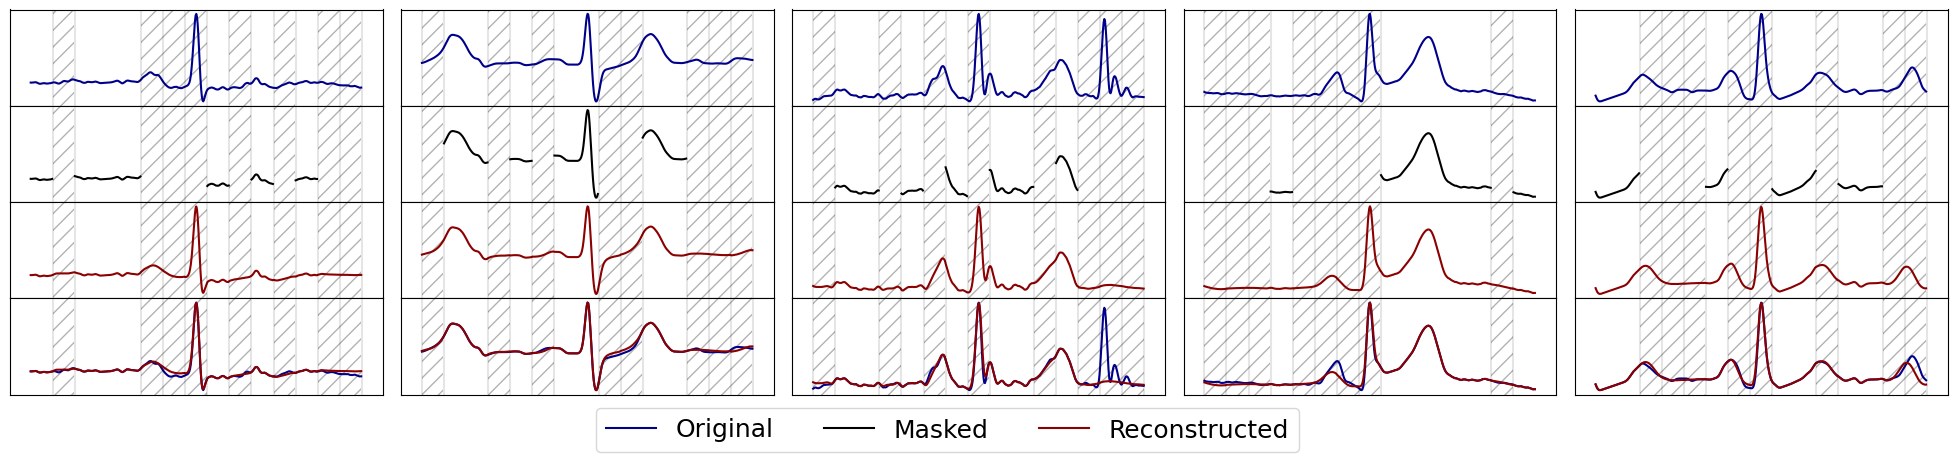

In [6]:
dataset = torch.load("./datasets/CINC2021_ul.pth")
index = [random.randint(0, len(dataset) - 1) for _ in range(5)]

fig = plt.figure(figsize=(25, 5))
axes = fig.subplots(nrows=4, ncols=5)
for i in range(5):
    masked_input, plot_ori, plot_masked, plot_recon, lines = recon(
        model, dataset[index[i]], 0.5, 32
    )
    plot_one_recon(axes, i, masked_input, plot_ori, plot_masked, plot_recon, lines)
lines = []
labels = []
axLine, axLabel = axes[0][0].get_legend_handles_labels()
lines.extend(axLine)
labels.extend(axLabel)
axLine, axLabel = axes[1][0].get_legend_handles_labels()
lines.extend(axLine)
labels.extend(axLabel)
axLine, axLabel = axes[2][0].get_legend_handles_labels()
lines.extend(axLine)
labels.extend(axLabel)

lgd = fig.legend(
    lines,
    labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.03),
    ncol=3,
    prop={"size": 18},
)
fig.subplots_adjust(hspace=0, wspace=0.05)
plt.show()

#### Different Datasets

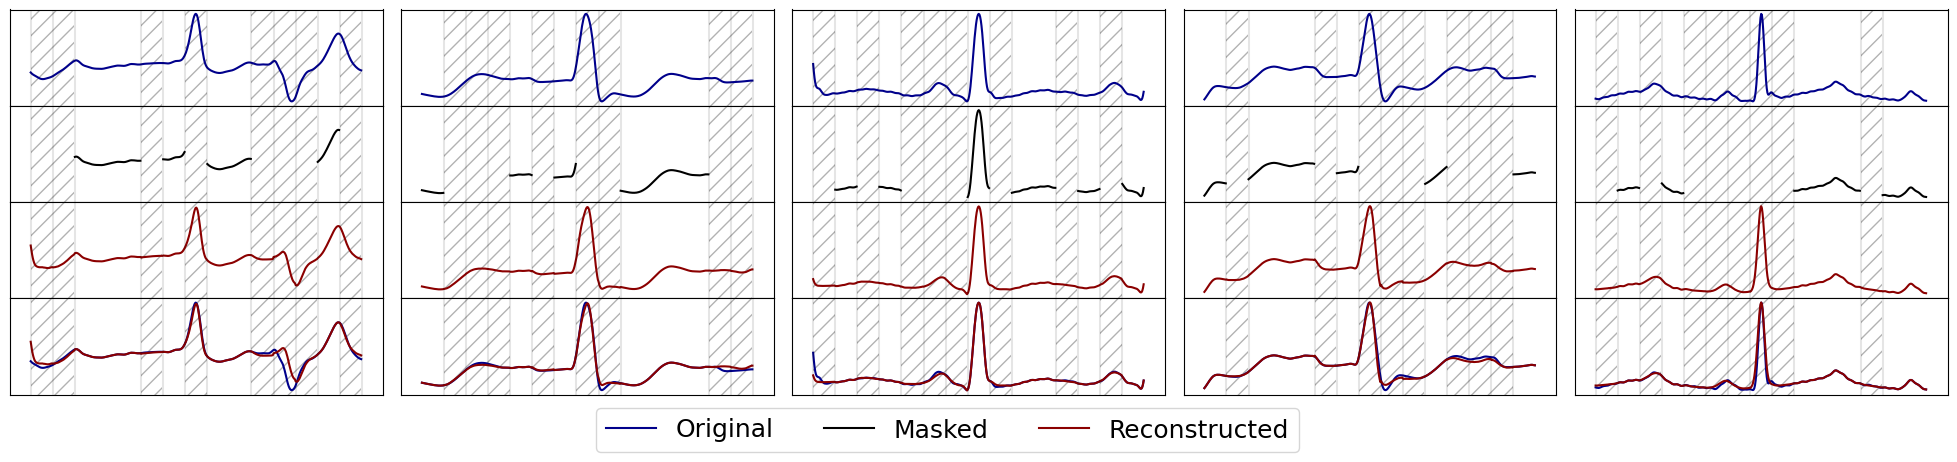

In [7]:
dataset = torch.load("./datasets/MITDB_af_test.pth")
index = [random.randint(0, len(dataset) - 1) for _ in range(5)]

fig = plt.figure(figsize=(25, 5))
axes = fig.subplots(nrows=4, ncols=5)
for i in range(5):
    masked_input, plot_ori, plot_masked, plot_recon, lines = recon(
        model, dataset[index[i]][0], 0.5, 32
    )
    plot_one_recon(axes, i, masked_input, plot_ori, plot_masked, plot_recon, lines)
lines = []
labels = []
axLine, axLabel = axes[0][0].get_legend_handles_labels()
lines.extend(axLine)
labels.extend(axLabel)
axLine, axLabel = axes[1][0].get_legend_handles_labels()
lines.extend(axLine)
labels.extend(axLabel)
axLine, axLabel = axes[2][0].get_legend_handles_labels()
lines.extend(axLine)
labels.extend(axLabel)

lgd = fig.legend(
    lines,
    labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.03),
    ncol=3,
    prop={"size": 18},
)
fig.subplots_adjust(hspace=0, wspace=0.05)
plt.show()

## Denoise

In [8]:
def denoise(model, dataset, index):
    wn = dataset.signals_wn[index]
    won = dataset.signals_won[index]
    latent, _, ids_restore = model.forward_encoder(wn.unsqueeze(0).unsqueeze(0), 0)
    pred = model.forward_decoder(latent, ids_restore)
    pred_unpatchified = model.unpatchify(pred).squeeze()
    plot_denoise = pred_unpatchified.detach().numpy()
    return won, wn, plot_denoise


def plot_one_denoise(axes, col, plot_target, plot_input, plot_denoise):
    axes[0][col].plot(
        plot_target, "darkblue", label="Target".center(20) + "\n" "(Without Noise)"
    )
    axes[0][col].set_xlim([-30, 510])
    axes[0][col].set_ylim([-1.1, 1.1])
    axes[0][col].set_xticks([])
    axes[0][col].set_yticks([])
    axes[1][col].plot(plot_input, "k", label="Input".center(16) + "\n" + "(With Noise)")
    axes[1][col].set_xlim([-30, 510])
    axes[1][col].set_ylim([-1.1, 1.1])
    axes[1][col].set_xticks([])
    axes[1][col].set_yticks([])
    axes[2][col].plot(
        plot_denoise, "darkred", label="Output".center(12) + "\n" + "(Denoised)"
    )
    axes[2][col].set_xlim([-30, 510])
    axes[2][col].set_ylim([-1.1, 1.1])
    axes[2][col].set_xticks([])
    axes[2][col].set_yticks([])
    axes[3][col].plot(
        plot_target, "darkblue", label="Target".center(20) + "\n" "(Without Noise)"
    )
    axes[3][col].plot(
        plot_denoise, "darkred", label="Output".center(12) + "\n" + "(Denoised)"
    )
    axes[3][col].set_xlim([-30, 510])
    axes[3][col].set_ylim([-1.1, 1.1])
    axes[3][col].set_xticks([])
    axes[3][col].set_yticks([])

### Configuration

In [9]:
model = mae_vit_base_patch32(signal_length=1440)
ckpt = torch.load(
    "./ckpts/dn_vit_base_p32_m50/checkpoint-199.pth"
)
model.load_state_dict(ckpt["model"])
dataset = torch.load("./datasets/ECGIDDB_dn_test.pth")

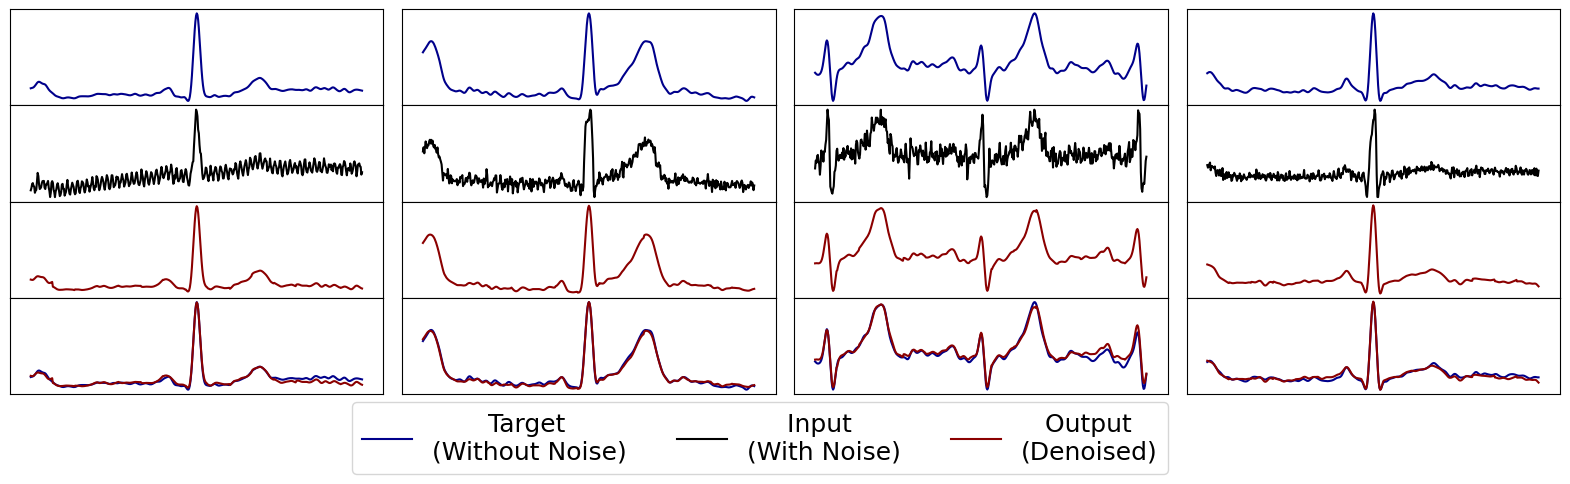

In [10]:
index = [random.randint(0, len(dataset) - 1) for _ in range(4)]
fig = plt.figure(figsize=(20, 5))
axes = fig.subplots(nrows=4, ncols=4)
for i in range(4):
    plot_target, plot_input, plot_denoise = denoise(model, dataset, index[i])
    plot_one_denoise(axes, i, plot_target, plot_input, plot_denoise)
lines = []
labels = []
axLine, axLabel = axes[0][0].get_legend_handles_labels()
lines.extend(axLine)
labels.extend(axLabel)
axLine, axLabel = axes[1][0].get_legend_handles_labels()
lines.extend(axLine)
labels.extend(axLabel)
axLine, axLabel = axes[2][0].get_legend_handles_labels()
lines.extend(axLine)
labels.extend(axLabel)
lgd = fig.legend(
    lines,
    labels,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.075),
    ncol=3,
    prop={"size": 18},
)
fig.subplots_adjust(hspace=0, wspace=0.05)
plt.show()